Files needed to run cells:


*   alpha_consensus.fasta
*   delta_consensus.fasta
*   omni1_consensus.fasta
*   omni2_consensus.fasta
*   wuhan.fa
*   wuhan_copy1.fasta  
*   Homo_sapiens.GRCh37.75.cds.all.fa
*   GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.csv



In [ ]:
'''
Code from CAI values by cai2
'''
try:
  import google.colab
  !pip install biopython
except ImportError:
  pass



from itertools import chain
import Bio.Data.CodonTable as ct
from scipy.stats import gmean
from collections import Counter

# get rid of Biopython warning
import warnings
from Bio import BiopythonWarning

warnings.simplefilter("ignore", BiopythonWarning)


def _synonymous_codons(genetic_code_dict):

    # invert the genetic code dictionary to map each amino acid to its codons
    codons_for_amino_acid = {}
    for codon, amino_acid in genetic_code_dict.items():
        codons_for_amino_acid[amino_acid] = codons_for_amino_acid.get(amino_acid, [])
        codons_for_amino_acid[amino_acid].append(codon)

    # create dictionary of synonymous codons
    # Example: {'CTT': ['CTT', 'CTG', 'CTA', 'CTC', 'TTA', 'TTG'], 'ATG': ['ATG']...}
    return {
        codon: codons_for_amino_acid[genetic_code_dict[codon]]
        for codon in genetic_code_dict.keys()
    }


_synonymous_codons = {
    k: _synonymous_codons(v.forward_table) for k, v in ct.unambiguous_dna_by_id.items()
}
_non_synonymous_codons = {
    k: {codon for codon in v.keys() if len(v[codon]) == 1}
    for k, v in _synonymous_codons.items()
}


def RSCU(sequences, genetic_code=11):


    if not isinstance(sequences, (list, tuple)):
        raise ValueError(
            "Be sure to pass a list of sequences, not a single sequence. "
            "To find the RSCU of a single sequence, pass it as a one element list."
        )

    # ensure all input sequences are divisible by three
    for sequence in sequences:
        if len(sequence) % 3 != 0:
            raise ValueError("Input sequence not divisible by three")
        if not sequence:
            raise ValueError("Input sequence cannot be empty")

    # count the number of each codon in the sequences
    sequences = (
        (sequence[i : i + 3].upper() for i in range(0, len(sequence), 3))
        for sequence in sequences
    )
    codons = chain.from_iterable(
        sequences
    )  # flat list of all codons (to be used for counting)
    counts = Counter(codons)

    # "if a certain codon is never used in the reference set... assign [its
    # count] a value of 0.5" (page 1285)
    for codon in ct.unambiguous_dna_by_id[genetic_code].forward_table:
        if counts[codon] == 0:
            counts[codon] = 0.5

    # determine the synonymous codons for the genetic code
    synonymous_codons = _synonymous_codons[genetic_code]

    # hold the result as it is being calulated
    result = {}

    # calculate RSCU values
    for codon in ct.unambiguous_dna_by_id[genetic_code].forward_table:
        result[codon] = counts[codon] / (
            (len(synonymous_codons[codon]) ** -1)
            * (sum((counts[_codon] for _codon in synonymous_codons[codon])))
        )

    return result


def relative_adaptiveness(sequences=None, RSCUs=None, genetic_code=11):
    r"""Calculates the relative adaptiveness/weight of codons.

    The relative adaptiveness is "the frequency of use of that codon compared to
    the frequency of the optimal codon for that amino acid" (page 1283).

    In math terms, :math:`w_{ij}`, the weight for the :math:`j` th codon for
    the :math:`i` th amino acid is

    .. math::

        w_{ij} = \frac{\text{RSCU}_{ij}}{\text{RSCU}_{imax}}

    where ":math:`\text{RSCU}_{imax}` [is] the RSCU... for the frequently used
    codon for the :math:`i` th amino acid" (page 1283).

    Args:
        sequences (list, optional): The reference set of sequences.
        RSCUs (dict, optional): The RSCU of the reference set.
        genentic_code (int, optional): The translation table to use. Defaults to 11, the standard genetic code.

    Note:
        Either ``sequences`` or ``RSCUs`` is required.

    Returns:
        dict: A mapping between each codon and its weight/relative adaptiveness.

    Raises:
        ValueError: When neither ``sequences`` nor ``RSCUs`` is provided.
        ValueError: See :func:`RSCU` for details.
    """

    # ensure user gave only and only one input
    if sum([bool(sequences), bool(RSCUs)]) != 1:
        raise TypeError("Must provide either reference sequences or RSCU dictionary")

    # calculate the RSCUs if only given sequences
    if sequences:
        RSCUs = RSCU(sequences, genetic_code=genetic_code)

    # determine the synonymous codons for the genetic code
    synonymous_codons = _synonymous_codons[genetic_code]

    # calculate the weights
    weights = {}
    for codon in RSCUs:
        weights[codon] = RSCUs[codon] / max(
            (RSCUs[_codon] for _codon in synonymous_codons[codon])
        )

    return weights


def CAI(sequence, weights=None, RSCUs=None, reference=None, genetic_code=11):
    r"""Calculates the codon adaptation index (CAI) of a DNA sequence.


    CAI is "the geometric mean of the RSCU values... corresponding to each of the
    codons used in that gene, divided by the maximum possible CAI for a gene of
    the same amino acid composition" (page 1285).

    In math terms, it is

    .. math::

        \left(\prod_{k=1}^Lw_k\right)^{\frac{1}{L}}

    where :math:`w_k` is the relative adaptiveness of the :math:`k` th codon in
    the gene (page 1286).

    Args:
        sequence (str): The DNA sequence to calculate the CAI for.
        weights (dict, optional): The relative adaptiveness of the codons in the reference set.
        RSCUs (dict, optional): The RSCU of the reference set.
        reference (list): The reference set of sequences.

    Note:
        One of ``weights``, ``reference`` or ``RSCUs`` is required.

    Returns:
        float: The CAI of the sequence.

    Raises:
        TypeError: When anything other than one of either reference sequences, or RSCU dictionary, or weights is provided.
        ValueError: See :func:`RSCU` for details.
        KeyError: When there is a missing weight for a codon.

    Warning:
        Will return nan if the sequence only has codons without synonyms.
    """

    # validate user input
    if sum([bool(reference), bool(RSCUs)], bool(weights)) != 1:
        raise TypeError(
            "Must provide either reference sequences, or RSCU dictionary, or weights"
        )

    # validate sequence
    if not sequence:
        raise ValueError("Sequence cannot be empty")

    # make sure input sequence can be divided into codons. If so, split into list of codons
    if (len(sequence) % 3) != 0:
        raise ValueError("Input sequence not divisible by three")
    sequence = sequence.upper()
    sequence = [sequence[i : i + 3] for i in range(0, len(sequence), 3)]

    # generate weights if not given
    if reference:
        weights = relative_adaptiveness(sequences=reference, genetic_code=genetic_code)
    elif RSCUs:
        weights = relative_adaptiveness(RSCUs=RSCUs, genetic_code=genetic_code)

    # create a list of the weights for the sequence, not counting codons without
    # synonyms -> "Also, the number of AUG and UGG codons are
    # subtracted from L, since the RSCU values for AUG and UGG are both fixed at
    # 1.0, and so do not contribute to the CAI." (page 1285)
    sequence_weights = []
    for codon in sequence:
        if codon not in _non_synonymous_codons[genetic_code]:
            try:
                sequence_weights.append(weights[codon])
            except KeyError:
                # ignore stop codons
                if codon in ct.unambiguous_dna_by_id[genetic_code].stop_codons:
                    pass
                else:
                    raise KeyError(
                        "Bad weights dictionary passed: missing weight for codon "
                        + str(codon)
                        + "."
                    )

    # return the geometric mean of the weights raised to one over the length of the sequence
    return float(gmean(sequence_weights))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.6 MB/s eta 0:00:00


In [ ]:
'''
Code to get our results.
'''

import numpy as np
import pandas as pd
# from Tools.scripts.dutree import display

df = pd.read_csv("GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.csv", index_col=0)
display(df.head())


# Grab Lung Column
lung = df.loc[:, "Lung"]
# Make it into a data frame
lung = lung.to_frame()
# Sort the data frame from greatest to least
lung = lung.sort_values(by = "Lung", ascending = False)
# Remove any rows with 0 in them
lung = lung.loc[(lung != 0).any(axis=1)]
# Remove rows with all 0s in a Dataframe
# df = df.loc[(df != 0).any(axis=1)]
# display(lung)


# Get ensembl ids
ensembl_ids = list(lung.index)
first_500 = ensembl_ids[:500]
sec_500 = ensembl_ids[500:1000]

for i in range(len(first_500)):
    final_id = first_500[i].split('.')[0]
    first_500[i] = final_id

for i in range(len(sec_500)):
    final_id = sec_500[i].split('.')[0]
    sec_500[i] = final_id


display(first_500[0])
display(sec_500[0])


'''
Read in the homo sapiens file that contains the human
genome.
Save the header as the key and the sequence as the value in a
dict.
'''

file_name = "Homo_sapiens.GRCh37.75.cds.all.fa"
count = 0
with open(file_name) as infile:
    new_dict = {}
    for l in infile:
        line = l.rstrip('\n')
        if line.startswith(">"):
            k = line.lstrip('>')
            if "gene:" in k:
                count = count + 1
            new_dict[k] = str()  # must initiate like string !!!!!!!!!!!!!
            # new_dict = {k:[]} #is possible alternative initiation
        else:
            new_dict[k] += line

# Double checking that the length of the dict is correct
# print(len(new_dict))
# Grab the headers of each sequence as a list
human_keys = list(new_dict.keys())
# display(human_keys[0])
# Grab the sequences as a list as well
human_seqs = list(new_dict.values())
# display(human_seqs[0])
'''
Remember, the index positions for the headers and seqs are the same
for each list.
'''



'''
Code to get the final list of sequences to be used
as a reference when using the CAI() function later on.
'''

# Dict to contain ensembl id (key) and corresponding seq (value)
final_hum_seqs = {}

# Iterating over the second 500 ensembl ids (based upon research paper)
for i in range(len(sec_500)):
    # Grab the ensembl id
    ensembl_id = sec_500[i]
#     print(ensembl_id)
    # Iterate over the headers for the human genes that are from the lung column
    for j in range(len(human_keys)):
        # Check if that ensembl id is in the human gene header
        if ensembl_id in human_keys[j]:
            # If the ensembl id is not already in the final hum seqs dict, then add to the dict
            if ensembl_id not in final_hum_seqs:
                # But, make sure that the length of the corresponding gene is divisible by 3.
                # Otherwise, we get an error when calling CAI() function later on
                ensembl_seq = human_seqs[j]
                if (len(ensembl_seq) % 3) == 0:
                    final_hum_seqs[ensembl_id] = ensembl_seq

# Check how many sequences from the second 500
# are in the final list.
# display(len(final_hum_seqs))
# Get the actual final ref sequences we will use in the CAI() function
final_ref_seqs = list(final_hum_seqs.values())
# Get the ensmeble ids for those final ref sequences
final_seqs_ids = list(final_hum_seqs.keys())
# print(final_seqs)


wuhan_positions = {"orf1a": [266, 13468],
            "orf1b": [13468, 21555],
            "orf3a": [25393, 26220],
            "S": [21563, 25384],
            "E": [26245, 26472],
            "M": [26523, 27191],
            "orf6": [27202, 27387],
            "orf7a": [27394, 27759],
            "orf7b": [27756, 27887],
            "orf8": [27894, 28259],
            "N": [28274, 29533],
            "orf9b": [28284, 28577]}

alpha_positions = {"orf1a": [229, 13422],
            "orf1b": [13422, 21509],
            "orf3a": [25338, 26165],
            "S": [21517, 25329],
            "E": [26190, 26417],
            "M": [26468, 27136],
            "orf6": [27147, 27332],
            "orf7a": [27339, 27704],
            "orf7b": [27701, 27832],
            "orf8": [27839, 28204],
            "N": [28218, 29477],
            "orf9b": [28228, 28521]}

delta_positions = {"orf1a": [234, 13436],
            "orf1b": [13436, 21523],
            "orf3a": [25355, 26182],
            "S": [21531, 25346],
            "E": [26207, 26434],
            "M": [26485, 27153],
            "orf6": [27164 , 27349],
            "orf7a": [27356, 27721],
            "orf7b": [27718, 27849],
            "orf8": [27856, 28209],
            "N": [28229, 29488],
            "orf9b": [28239, 28532]}


# EALRY OMIC
omic1_positions = {"orf1a": [225, 13415],
                  "orf1b": [13415, 21502],
                  "orf3a": [25322, 26149],
                  "S": [21510, 25313],
                  "E": [26174, 26401],
                  "M": [26452, 27120],
                  "orf6": [27131, 27316],
                  "orf7a": [27323, 27688],
                  "orf7b": [27685, 27816],
                  "orf8": [27823, 28188],
                  "N": [28203, 29453],
                  "orf9b": [28213, 28497]
                   }

# LATER OMIC
omic2_positions = {"orf1a": [215, 13408],
                  "orf1b": [13408, 21495],
                  "orf3a": [25324, 26151],
                  "S": [21503, 25315],
                  "E": [26176, 26403],
                  "M": [26454, 27122],
                  "orf6": [27133, 27312],
                  "orf7a": [27325, 27690],
                  "orf7b": [27687, 27818],
                  "orf8": [27825, 28190],
                  "N": [28205, 29455],
                  "orf9b": [28215, 28499]
                  }


def get_nucleotides_seqs(filename, start_stop_dict):
    orf_genes = []
    with open(filename, "r") as infile:
        cons_seq = infile.readline()
        cons_seq = cons_seq.replace("-", "")
    for values in start_stop_dict.values():
        start = values[0] - 1
        stop = values[1]
        orf_gene = cons_seq[start:stop]
        orf_genes.append(orf_gene)
    return orf_genes


def use_CAI(orf_genes_list, human_ref_list):
#     print("Function called")
    cai_list = []
    for seq in orf_genes_list:
        cai_num = CAI(seq, weights=None, RSCUs=None, reference=human_ref_list)
        cai_list.append(cai_num)
    return cai_list


# with open("wuhan_copy.fasta", "r") as infile:
# #     next(infile)
#       wuh_seq1 = infile.readlines()
# #     lines = infile.readline()
# #     wuh_seq = ""
# #     for line in lines:
# #         seq = line.strip()
# #         wuh_seq = wuh_seq + line
# # print(wuh_seq1)
# final_line = ""
# for line in wuh_seq1:
#     g = line.strip()
#     final_line = final_line + g
# print(final_line)
# with open("wuhan_copy1.fasta", "w") as infile:
#     infile.write(final_line)

# with open("wuhan_copy.fasta", "w") as infile:
#     infile.write(wuh_seq)

# with open("wuhan_copy.fasta", "r") as infile:
#     wuhan = infile.readline()
# print(wuhan)

wuhan_orf_seqs = get_nucleotides_seqs("wuhan_copy1.fasta", wuhan_positions)
# display(wuhan_orf_seqs)
alpha_orf_seqs = get_nucleotides_seqs("alpha_consensus.fasta", alpha_positions)
delta_orf_seqs = get_nucleotides_seqs("delta_consensus.fasta", delta_positions)
omic1_orf_seqs = get_nucleotides_seqs("Omni1_consensus.fasta", omic1_positions)
omic2_orf_seqs = get_nucleotides_seqs("omni2_consensus.fasta", omic2_positions)




# Wuhan
wuhan_array = use_CAI(wuhan_orf_seqs, final_ref_seqs)
wuhan_array = np.array(wuhan_array)
# print("Wuhan")
# display(wuhan_array)
wuhan_df = pd.DataFrame(wuhan_array, index = ["orf1a","orf1b", "orf3a", "S", "E", "M", "orf6", "orf7a",
                                             "orf7b", "orf8", "N", "orf9b"], columns = ["Wuhan"])
display(wuhan_df)

# Alpha
alpha_array = use_CAI(alpha_orf_seqs, final_ref_seqs)
alpha_array = np.array(alpha_array)
# print("Alpha")
# display(alpha_array)
alpha_df = pd.DataFrame(alpha_array, index = ["orf1a","orf1b", "orf3a", "S", "E", "M", "orf6", "orf7a",
                                              "orf7b", "orf8", "N", "orf9b"], columns = ["Alpha"])
display(alpha_df)


# Delta
delta_array = use_CAI(delta_orf_seqs, final_ref_seqs)
delta_array = np.array(delta_array)
# print("Delta")
# display(delta_array)
delta_df = pd.DataFrame(delta_array, index = ["orf1a","orf1b", "orf3a", "S", "E", "M", "orf6", "orf7a",
                                             "orf7b", "orf8", "N", "orf9b"], columns = ["Delta"])
display(delta_df)


# Omicron 1
omic1_array = use_CAI(omic1_orf_seqs, final_ref_seqs)
omic1_array = np.array(omic1_array)
# print("Omin 1")
# display(omic1_array)
omic1_df = pd.DataFrame(omic1_array, index = ["orf1a","orf1b", "orf3a", "S", "E", "M", "orf6", "orf7a",
                                             "orf7b", "orf8", "N", "orf9b"], columns = ["Early Omicron"])
display(omic1_df)


# Omicron 2
omic2_array = use_CAI(omic2_orf_seqs, final_ref_seqs)
omic2_array = np.array(omic2_array)
# display(type(alpha_df))
print("Omin 2")
display(omic2_array)

omic2_df = pd.DataFrame(omic2_array, index = ["orf1a","orf1b", "orf3a", "S", "E", "M", "orf6", "orf7a",
                                             "orf7b", "orf8", "N", "orf9b"], columns = ["Late Omicron"])
display(omic2_df)


final_cai_table = wuhan_df.join(alpha_df)
final_cai_table = final_cai_table.join(delta_df)
final_cai_table = final_cai_table.join(omic1_df)
final_cai_table = final_cai_table.join(omic2_df)
print("Final CAI Table")
display(final_cai_table)
import dataframe_image as dfi
dfi.export(final_cai_table,"CAI_Table.png")

,Description,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
Name,,,,,,,,,,,,,,,,,,,,,
ENSG00000223972.5,DDX11L1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.166403,0.00000,0.00000,0.00000,0.00000
ENSG00000227232.5,WASH7P,4.06403,3.37111,2.68549,4.04762,3.90076,3.63963,5.16375,1.43859,1.69285,...,5.93298,6.13265,4.19378,5.92631,3.06248,4.702530,6.27255,7.19001,5.74554,2.64743
ENSG00000278267.1,MIR6859-1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000
ENSG00000243485.5,MIR1302-2HG,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.054223,0.00000,0.00000,0.00000,0.00000
ENSG00000237613.2,FAM138A,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000


'ENSG00000198886'

'ENSG00000198355'

,Wuhan
orf1a,0.570444
orf1b,0.571517
orf3a,0.571668
S,0.585962
E,0.502739
M,0.570068
orf6,0.522035
orf7a,0.584538
orf7b,0.534004
orf8,0.568438


,Alpha
orf1a,0.570416
orf1b,0.571231
orf3a,0.571668
S,0.585936
E,0.502739
M,0.570068
orf6,0.522035
orf7a,0.584538
orf7b,0.534004
orf8,0.566458


,Delta
orf1a,0.570160
orf1b,0.570664
orf3a,0.568815
S,0.585121
E,0.502739
M,0.570068
orf6,0.522035
orf7a,0.583985
orf7b,0.537478
orf8,0.561246


,Early Omicron
orf1a,0.570335
orf1b,0.571158
orf3a,0.570463
S,0.586695
E,0.496640
M,0.570498
orf6,0.525741
orf7a,0.584538
orf7b,0.534412
orf8,0.568438


Omin 2


array([0.57078468, 0.571394  , 0.57014567, 0.58645144, 0.49613381,
       0.57010346, 0.52176314, 0.58453819, 0.53441238, 0.56704157,
       0.62725028, 0.59027366])

,Late Omicron
orf1a,0.570785
orf1b,0.571394
orf3a,0.570146
S,0.586451
E,0.496134
M,0.570103
orf6,0.521763
orf7a,0.584538
orf7b,0.534412
orf8,0.567042


Final CAI Table


,Wuhan,Alpha,Delta,Early Omicron,Late Omicron
orf1a,0.570444,0.570416,0.570160,0.570335,0.570785
orf1b,0.571517,0.571231,0.570664,0.571158,0.571394
orf3a,0.571668,0.571668,0.568815,0.570463,0.570146
S,0.585962,0.585936,0.585121,0.586695,0.586451
E,0.502739,0.502739,0.502739,0.496640,0.496134
M,0.570068,0.570068,0.570068,0.570498,0.570103
orf6,0.522035,0.522035,0.522035,0.525741,0.521763
orf7a,0.584538,0.584538,0.583985,0.584538,0.584538
orf7b,0.534004,0.534004,0.537478,0.534412,0.534412
orf8,0.568438,0.566458,0.561246,0.568438,0.567042


ModuleNotFoundError: ignored

In [ ]:
# import seaborn as sns
# sns.heatmap(final_cai_table, annot=True)

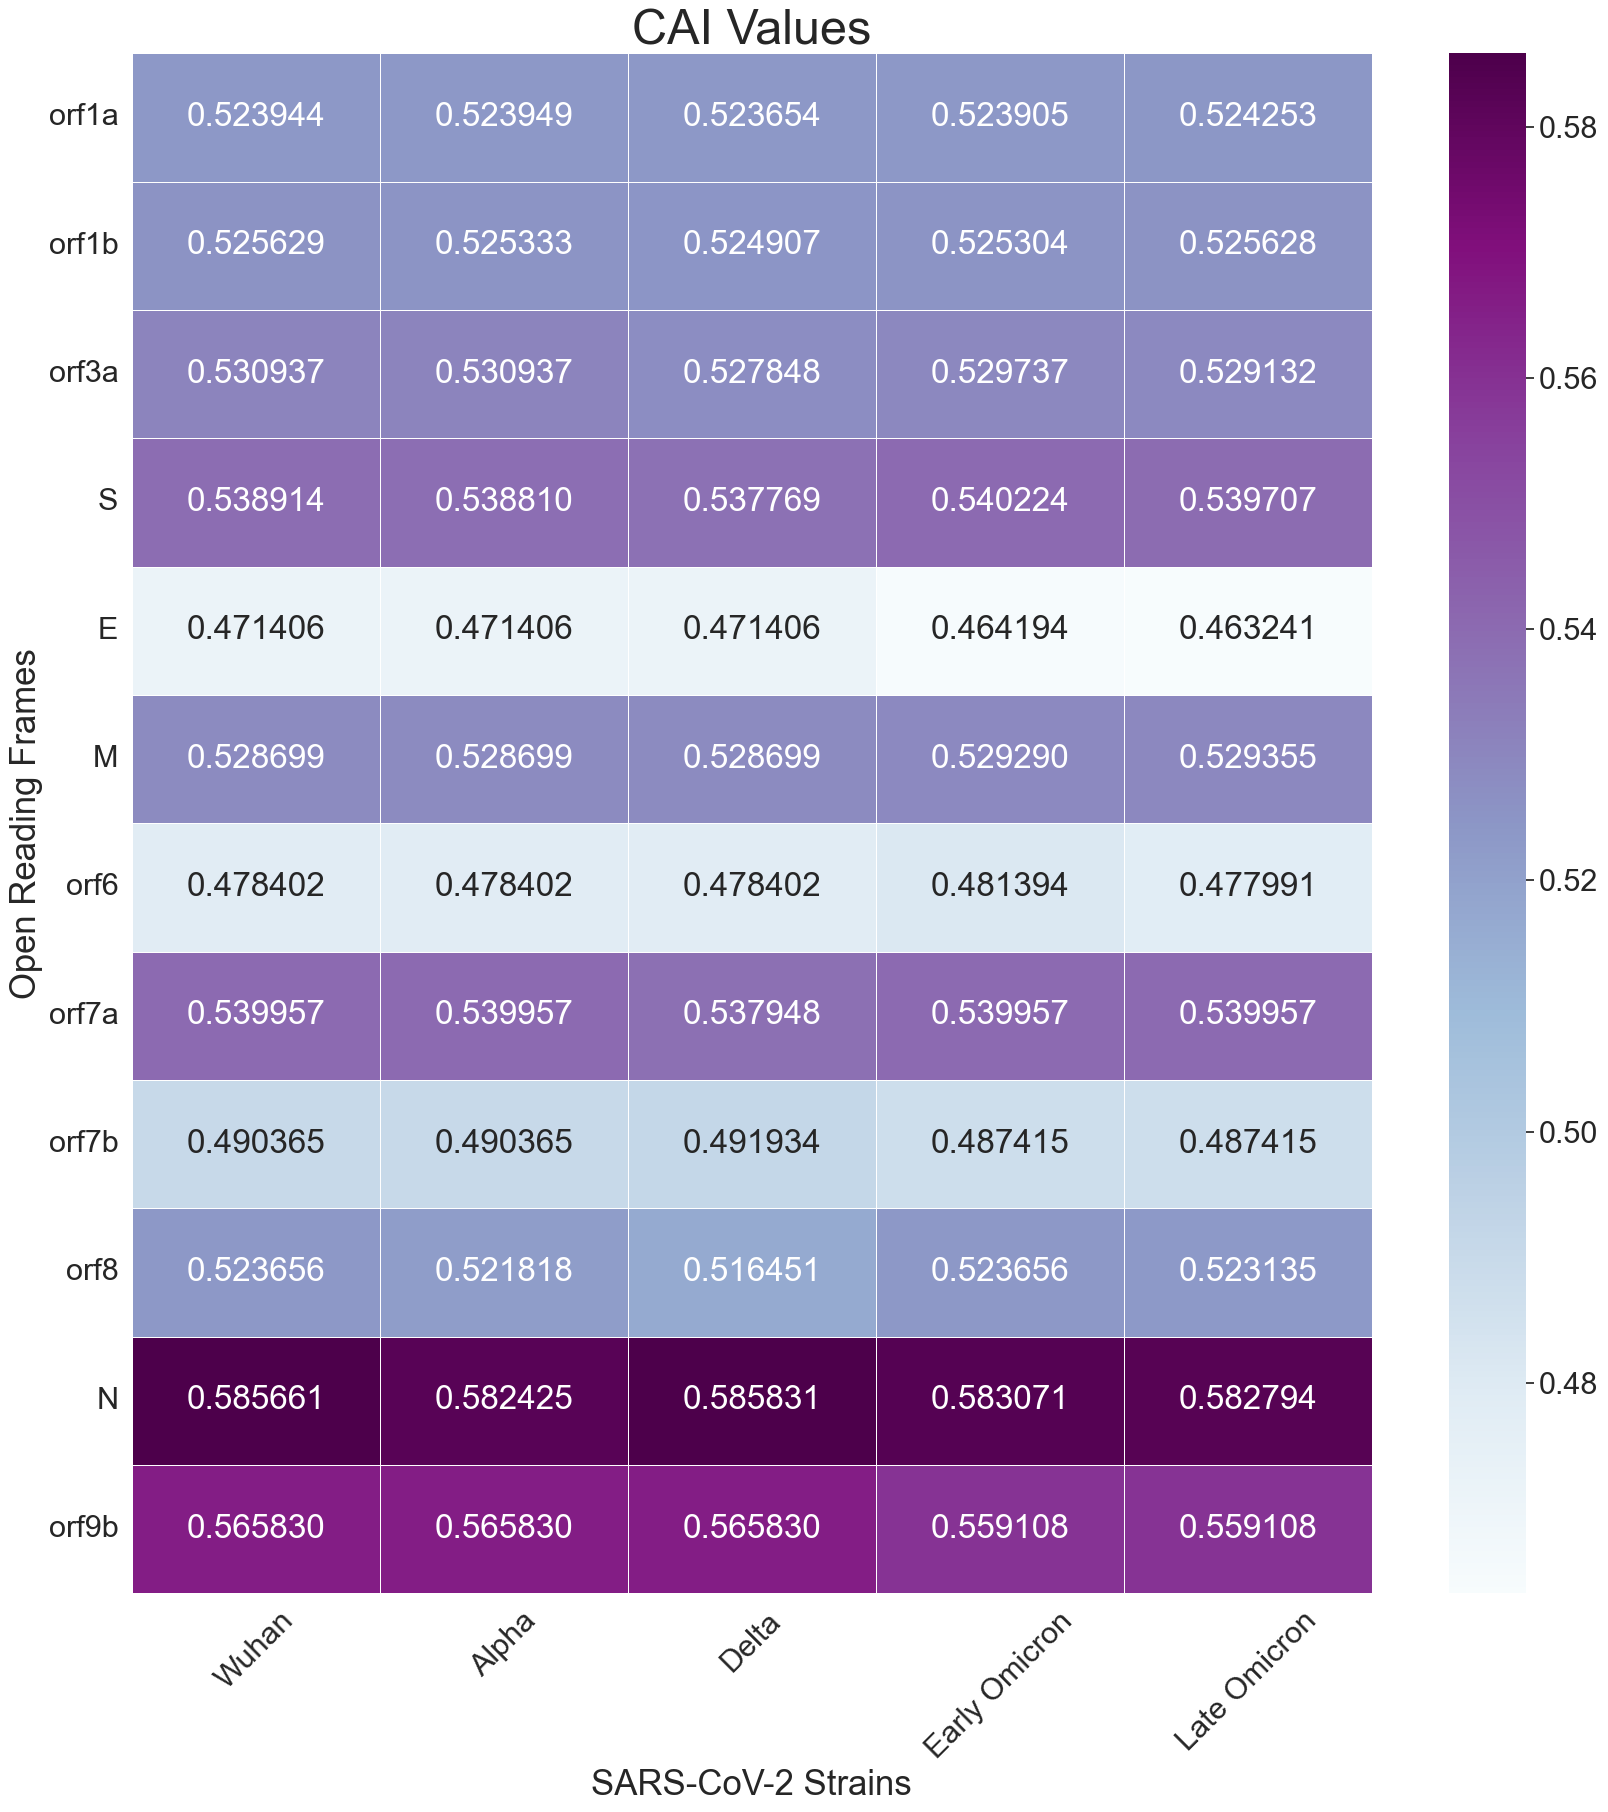

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(final_cai_table, annot=True, linewidths=.5, fmt=".6f", cmap="BuPu")
sns.set(font_scale=1)
ax.set_title("CAI Values", fontsize=35)
ax.set_xlabel("SARS-CoV-2 Variants", fontsize=25)
ax.set_ylabel("Open Reading Frames", fontsize=25)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
sns.set(font_scale=2) # font size 2
# plt.savefig("CAI.png", format="png")
plt.show()

In [ ]:
'''
To get RSCU values
'''

wuhan_orf_seqs = get_nucleotides_seqs("wuhan_copy1.fasta", wuhan_positions)
# display(wuhan_orf_seqs)
alpha_orf_seqs = get_nucleotides_seqs("alpha_consensus.fasta", alpha_positions)
delta_orf_seqs = get_nucleotides_seqs("delta_consensus.fasta", delta_positions)
omic1_orf_seqs = get_nucleotides_seqs("Omni1_consensus.fasta", omic1_positions)
omic2_orf_seqs = get_nucleotides_seqs("omni2_consensus.fasta", omic2_positions)


wuhan_rscu = RSCU(wuhan_orf_seqs)
alpha_rscu = RSCU(alpha_orf_seqs)
delta_rscu = RSCU(delta_orf_seqs)
omic1_rscu = RSCU(omic1_orf_seqs)
omic2_rscu = RSCU(omic2_orf_seqs)


def create_rscu_df(ref_rscu_list, ref_name):
    values = ref_rscu_list.values()
    keys = ref_rscu_list.keys()
    df = pd.DataFrame(values, index=keys, columns=[ref_name])
    return df



# print(RSCU(wuhan_orf_seqs))
wuhan_rscu = RSCU(wuhan_orf_seqs)
wuhan_rscu_df = create_rscu_df(wuhan_rscu, "Wuhan")
display(wuhan_rscu_df)


# print(RSCU(alpha_orf_seqs))
alpha_rscu = RSCU(alpha_orf_seqs)
alpha_rscu_df = create_rscu_df(alpha_rscu, "Alpha")
display(alpha_rscu_df)

# print(RSCU(delta_orf_seqs))
delta_rscu = RSCU(delta_orf_seqs)
delta_rscu_df = create_rscu_df(delta_rscu, "Delta")
display(delta_rscu_df)

# print(RSCU(omic1_orf_seqs))
omic1_rscu = RSCU(omic1_orf_seqs)
omic1_rscu_df = create_rscu_df(omic1_rscu, "Early Omicron")
display(omic1_rscu_df)

# print(RSCU(omic2_orf_seqs))
omic2_rscu = RSCU(omic2_orf_seqs)
omic2_rscu_df = create_rscu_df(omic2_rscu, "Late Omicron")
display(omic2_rscu_df)


final_rscu_df = wuhan_rscu_df.join(alpha_rscu_df)
final_rscu_df = final_rscu_df.join(delta_rscu_df)
final_rscu_df = final_rscu_df.join(omic1_rscu_df)
final_rscu_df = final_rscu_df.join(omic2_rscu_df)
display(final_rscu_df)

# import dataframe_image as dfi
# dfi.export(final_rscu_df.iloc[0:21,:],"RSCU_Table1.png")
# dfi.export(final_rscu_df.iloc[21:40,:],"RSCU_Table2.png")
# dfi.export(final_rscu_df.iloc[40:,:],"RSCU_Table3.png")

,Wuhan
TTT,1.397590
TTC,0.602410
TTA,1.637527
TTG,1.061834
TCT,1.945701
...,...
GAG,0.562500
GGT,2.339100
GGC,0.712803
GGA,0.823529


,Alpha
TTT,1.405622
TTC,0.594378
TTA,1.634043
TTG,1.059574
TCT,1.945455
...,...
GAG,0.562500
GGT,2.343154
GGC,0.714038
GGA,0.818024


,Delta
TTT,1.407258
TTC,0.592742
TTA,1.647932
TTG,1.056204
TCT,1.957895
...,...
GAG,0.559284
GGT,2.325260
GGC,0.719723
GGA,0.830450


,Early Omicron
TTT,1.400000
TTC,0.600000
TTA,1.632871
TTG,1.056564
TCT,1.948407
...,...
GAG,0.560538
GGT,2.341463
GGC,0.717770
GGA,0.815331


,Late Omicron
TTT,1.406814
TTC,0.593186
TTA,1.641026
TTG,1.064103
TCT,1.951589
...,...
GAG,0.571429
GGT,2.336842
GGC,0.722807
GGA,0.814035


,Wuhan,Alpha,Delta,Early Omicron,Late Omicron
TTT,1.397590,1.405622,1.407258,1.400000,1.406814
TTC,0.602410,0.594378,0.592742,0.600000,0.593186
TTA,1.637527,1.634043,1.647932,1.632871,1.641026
TTG,1.061834,1.059574,1.056204,1.056564,1.064103
TCT,1.945701,1.945455,1.957895,1.948407,1.951589
...,...,...,...,...,...
GAG,0.562500,0.562500,0.559284,0.560538,0.571429
GGT,2.339100,2.343154,2.325260,2.341463,2.336842
GGC,0.712803,0.714038,0.719723,0.717770,0.722807
GGA,0.823529,0.818024,0.830450,0.815331,0.814035


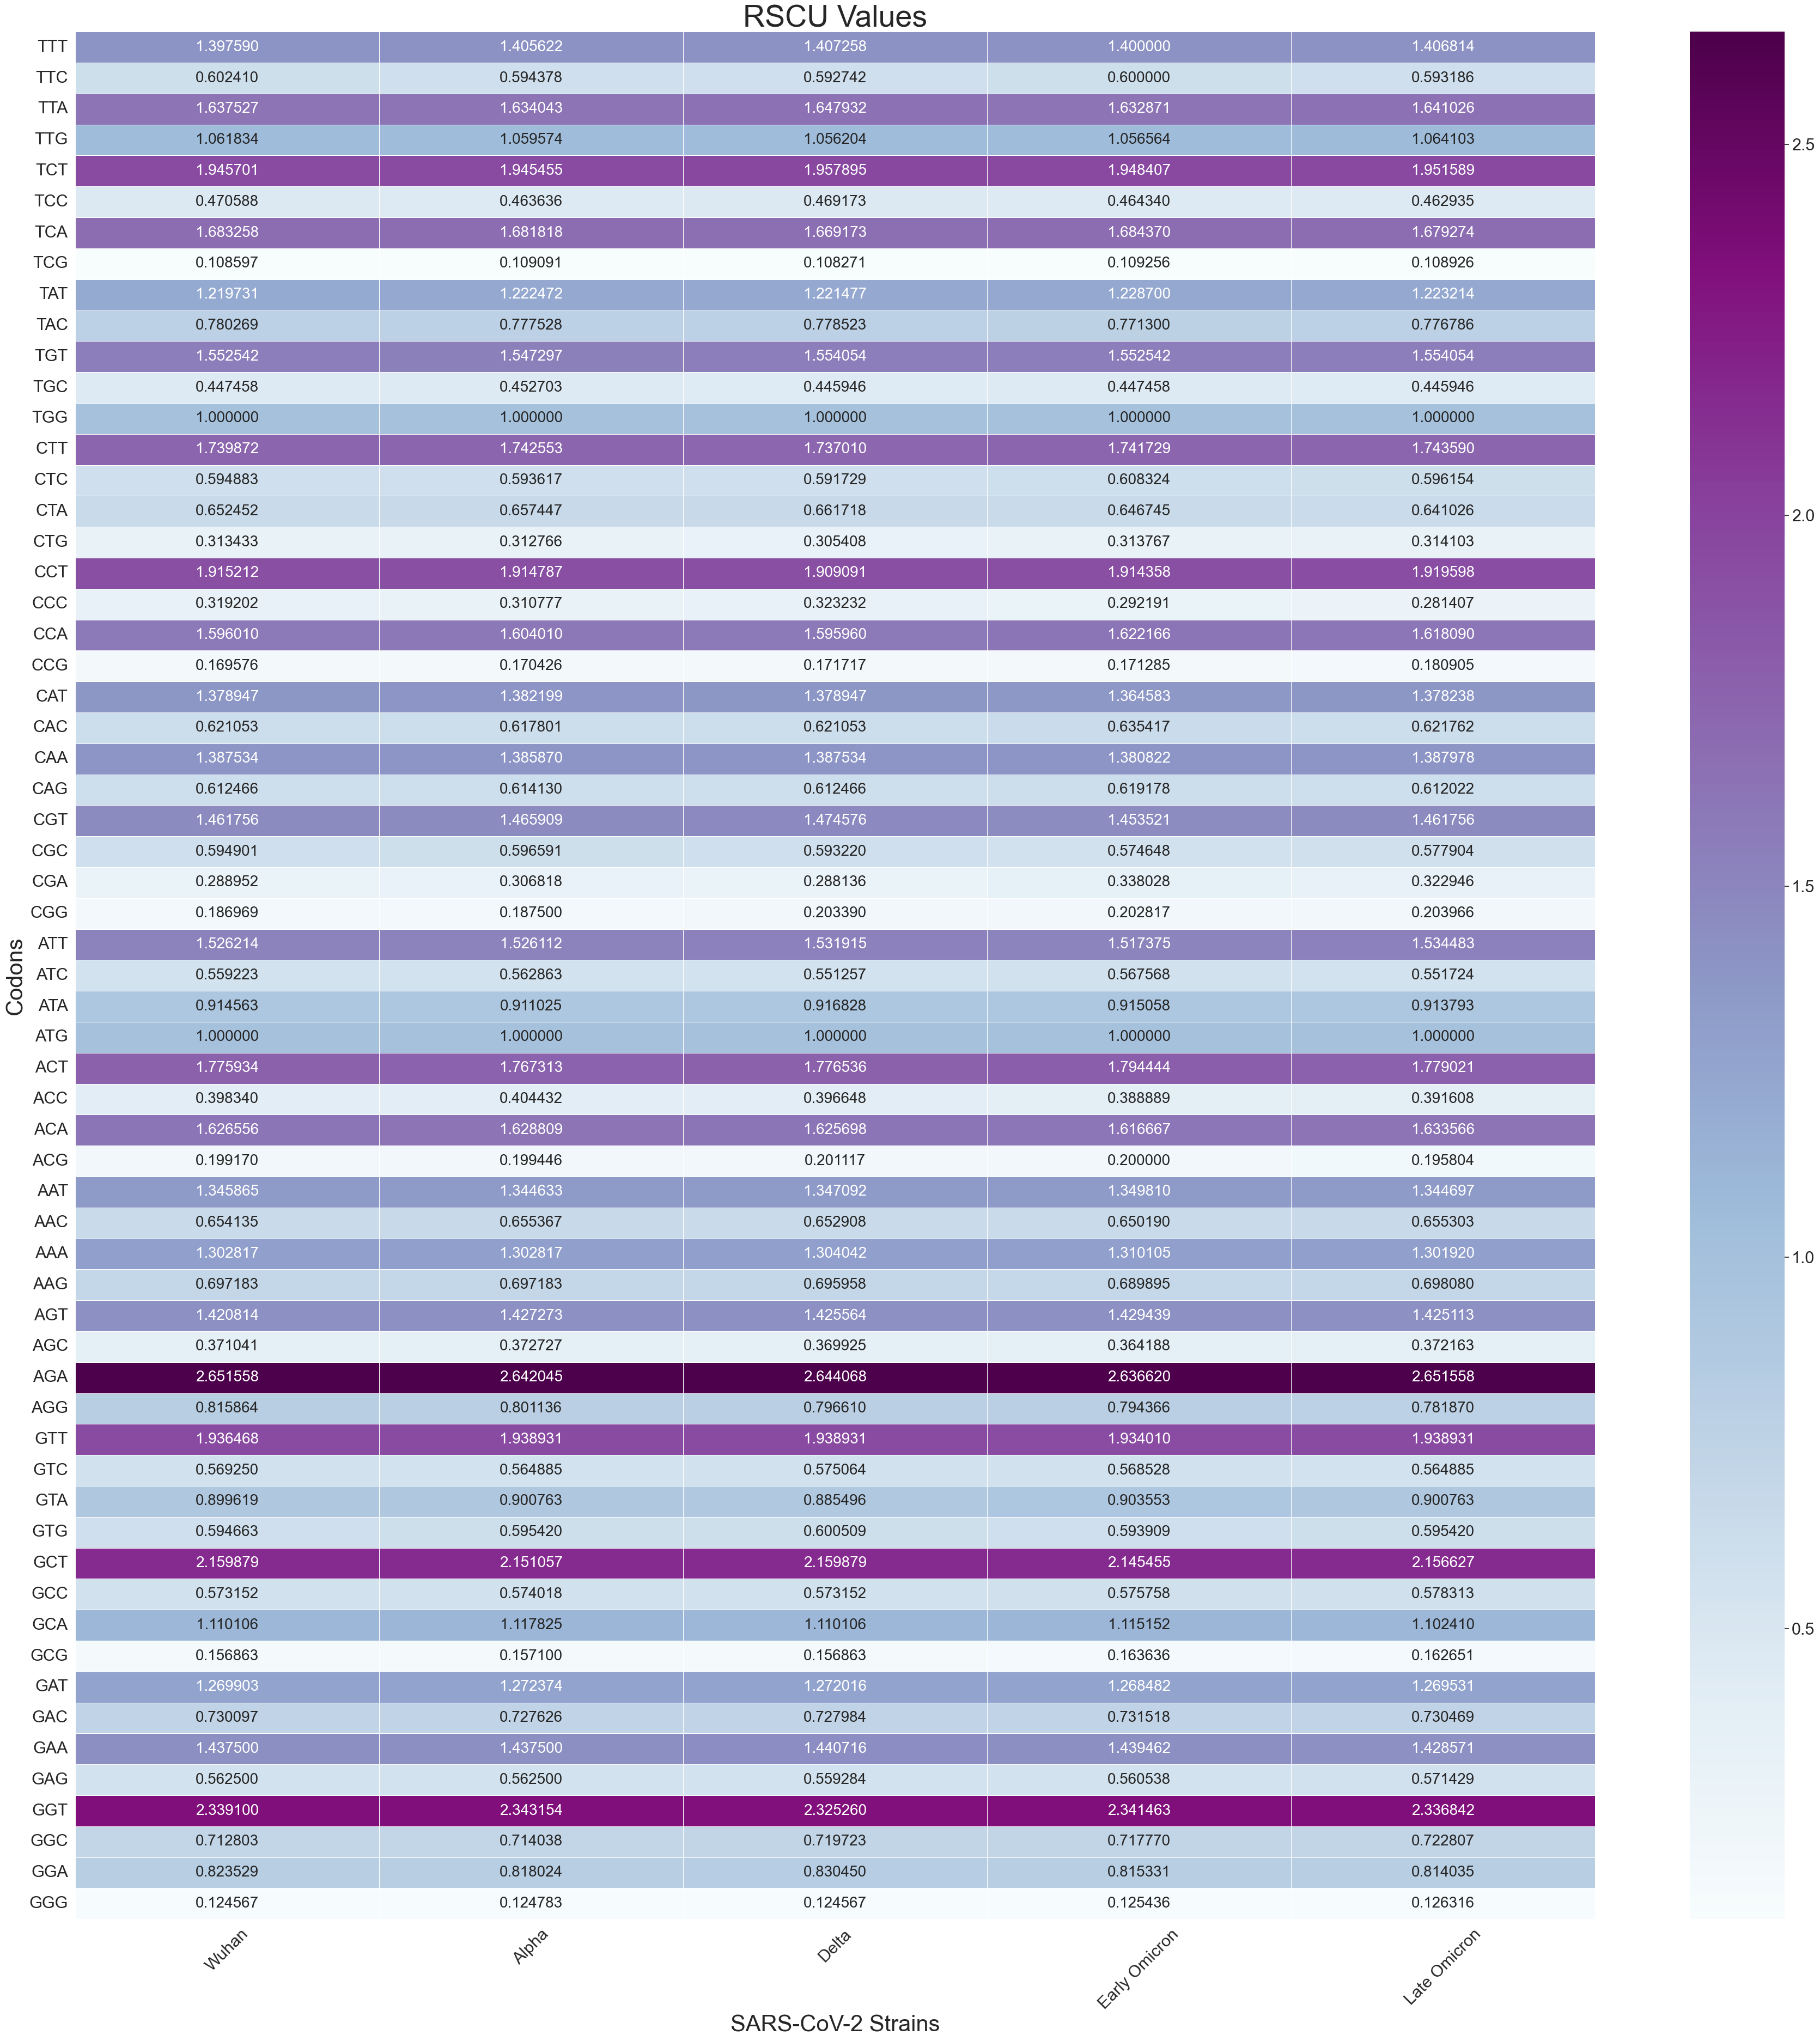

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(45,45))         # Sample figsize in inches
sns.heatmap(final_rscu_df, annot=True, linewidths=.5, fmt=".6f", cmap="BuPu", annot_kws={'size': 20})
# sns.set(font_scale=1.8)
ax.set_title("RSCU Values", fontsize=40)
ax.set_xlabel("SARS-CoV-2 Variant", fontsize=30)
ax.set_ylabel("Codons", fontsize=30)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
sns.set(font_scale=2) # font size 2
# plt.savefig("RSCU.png", format="png")
plt.show()